**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree 
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
import scipy
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances

Импортирую scipy, чтобы обеспечить возможность работы с разреженными матрицами в последнем задании

In [3]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.nb_num = n_neighbors
        self.alg = algorithm

    def fit(self, X, y):
        if not isinstance(X, scipy.sparse.csr_matrix):
            self.x_train = X.astype(float)
            self.y_train = y
            if self.alg == 'kd_tree':
                self.kd_data = KDTree(self.x_train)
        else:
            self.x_train = X
            self.y_train = y

    def predict(self, X, metric='euclidean'):
        condition = (not isinstance(X, scipy.sparse.csr_matrix))
        if self.alg == 'brute' and condition:
            points_given = X.shape[0]
            Xfl = X.astype(float)
            helper = np.ones(points_given).astype(int)
            helper = helper*self.x_train.shape[0]
            X_prep = np.repeat(Xfl, helper, axis=0)
            Xh = self.x_train[np.newaxis, ]
            Xh = np.repeat(Xh, points_given, axis=0)
            Xh = Xh.reshape(-1, X.shape[1])
            if metric == 'euclidean':
                res = self.Euclid(Xh, X_prep)
            if metric == 'cosine':
                res = self.Cosine(Xh, X_prep)
            Xh = None
            hold = res.reshape(-1, self.x_train.shape[0])
            temp = np.argpartition(hold, self.nb_num)
            temp = temp[::, 0:self.nb_num]
            hhh = self.y_train[temp]
            minl = np.max(hhh)+1
            helper = np.apply_along_axis(np.bincount, 1, hhh, minlength=minl)
            return np.argmax(helper, 1)
        elif self.alg == 'kd_tree':
            dist, index = self.kd_data.query(X.astype(float), k=self.nb_num)
            hhh = self.y_train[index]
            minl = np.max(hhh)+1
            helper = np.apply_along_axis(np.bincount, 1, hhh, minlength=minl)
            return np.argmax(helper, 1)
        elif self.alg == 'brute' and (isinstance(X, scipy.sparse.csr_matrix)):
            X = X.reshape(X.shape[0], -1)
            dist = pairwise_distances(X, self.x_train, metric=metric)
            temp = np.argpartition(dist, self.nb_num)
            temp = temp[::, 0:self.nb_num]
            hhh = self.y_train[temp]
            minl = np.max(hhh)+1
            helper = np.apply_along_axis(np.bincount, 1, hhh, minlength=minl)
            return np.argmax(helper, 1)

    def Euclid(self, A, B):
        return (np.sqrt(((A-B)**2).sum(axis=1))).astype(float)

    def Cosine(self, A, B):
        self.zr = (np.sqrt((A*A).sum(axis=1))*np.sqrt((B*B).sum(axis=1)))
        self.zr_ind = np.where(np.isclose(self.zr, 0.000))
        self.zr[self.zr_ind] = 1
        return 1-(A*B).sum(axis=1)/self.zr

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [8]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 1.09 ms, sys: 433 µs, total: 1.52 ms
Wall time: 1.14 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 28 µs, sys: 4 µs, total: 32 µs
Wall time: 35 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 3.36 ms, sys: 1.6 ms, total: 4.95 ms
Wall time: 3.53 ms


array([0, 2, 2, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 1, 0])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 1.29 ms, sys: 1.13 ms, total: 2.41 ms
Wall time: 1.37 ms


array([0, 2, 2, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 1, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 1.61 ms, sys: 1.6 ms, total: 3.22 ms
Wall time: 4.36 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 192 µs, sys: 25 µs, total: 217 µs
Wall time: 203 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 4.58 ms, sys: 3.74 ms, total: 8.32 ms
Wall time: 5.98 ms


array([1, 0, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 951 µs, sys: 592 µs, total: 1.54 ms
Wall time: 1.09 ms


array([1, 0, 1, 0, 1, 2, 2, 0, 0, 2, 1, 1, 2, 2, 0])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df = 0.006, stop_words = "english")
X = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=3)
max_points = 20

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [24]:
def validation(skf, X, target, metric='euclidean'):
    results = []
    for num_n in range(1, max_points):
        res = 0.0
        my_clf1 = MyKNeighborsClassifier(n_neighbors=num_n, algorithm='brute')
        for train, test in skf.split(X, target):
            my_clf1.fit(X[train], target[train])
            temp = my_clf1.predict(X[test], metric=metric)
            res = res + accuracy_score(target[test], temp)
        results.append(res/3.0)
        print(res/3.0)
    return results

In [25]:
def visualize_graph(results, max_points, title="Euclidean Countvectorizer"):
    plt.figure(figsize=(14, 10))
    plt.title(title)
    plt.plot(np.arange(1, max_points), results, color='green', label="sparse")
    plt.xlabel('Neighbors number', fontsize=20)
    plt.ylabel('Score', fontsize=20)
    plt.grid()
    plt.legend()
    plt.show()
    help1 = results[np.argmax(np.array(results))]
    help2 = np.argmax(np.array(results))+1
    print("best res: ", help1, " neighbours: ", help2)

0.2762062320218512
0.1941841605472884
0.2153963959479794
0.21247930406736534
0.20611569437613367
0.20019398379795428
0.19842648108263106
0.19303501663220426
0.19179759600508392
0.188881089980005
0.18366620238787215
0.17880503093364095
0.17580006072275448
0.17482786861350677
0.17049696672124967
0.16758008574862823
0.16855227785787594
0.1647516923960357
0.1629838616016128


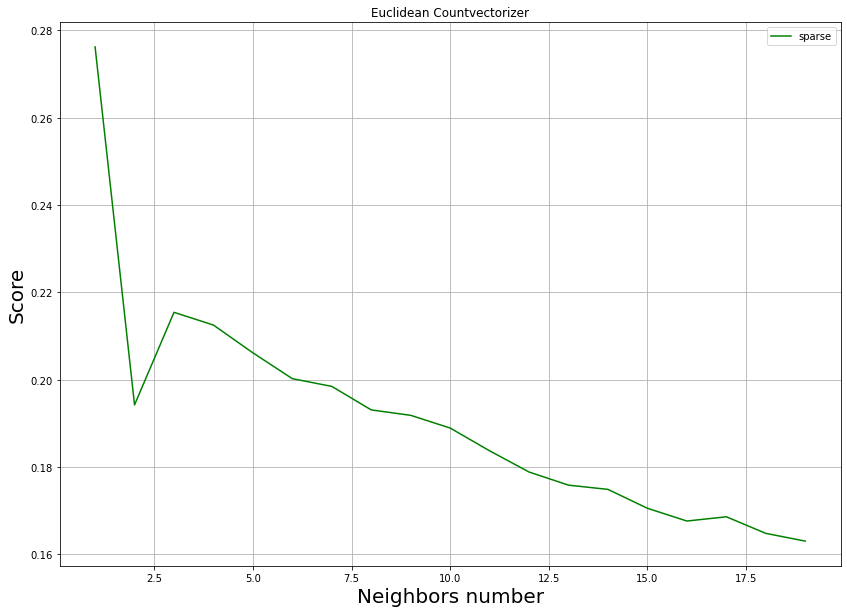

best res:  0.2762062320218512  neighbours:  1


In [26]:
results = validation(skf, X, target)
visualize_graph(results, max_points)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

0.5357079886042194
0.493989075340928
0.5309354219411241
0.5446352318145989
0.558953634830527
0.5654945009724733
0.5702673957146683
0.5727421901004663
0.5775149442373327
0.5818461039060254
0.5858233130946023
0.5883864779293222
0.5907732065110766
0.5928944253643014
0.5945737216702526
0.5956340030177653
0.5982858898147282
0.5998767453690932
0.5997000747739136


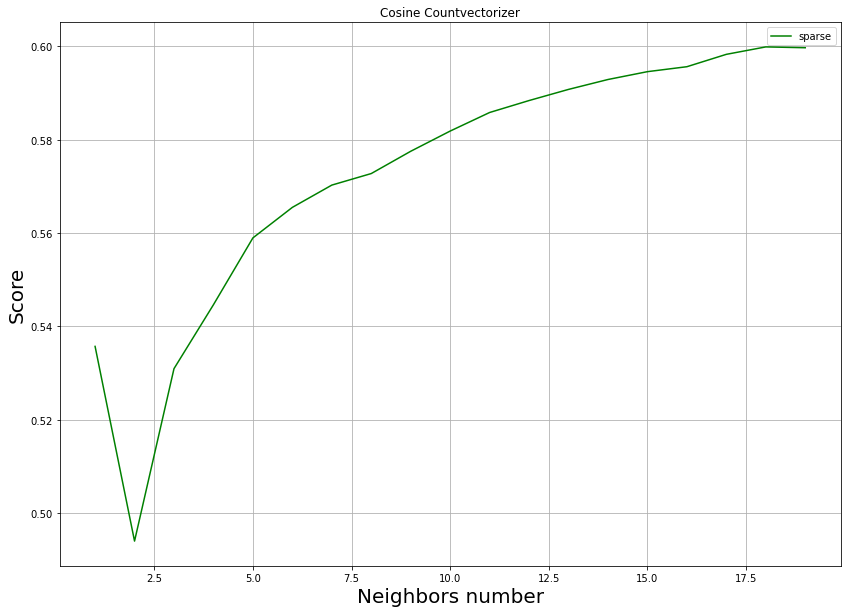

best res:  0.5998767453690932  neighbours:  18


In [27]:
results = validation(skf, X, target, metric = 'cosine')
visualize_graph(results, max_points, title = "Cosine Countvectorizer")

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df = 0.006, stop_words = "english")
X = vectorizer.fit_transform(data)

0.1552057388720959
0.08591163667508143
0.10703557192951474
0.10031862104792401
0.096783006327521
0.09307090848570966
0.09139144814020862
0.09059599692880467
0.08820947925504297
0.08387850706012161
0.08405527139218678
0.0852928326246356
0.08485044139293386
0.08158028953261758
0.08122671400004443
0.08166851937621102
0.07848687857014504
0.07919405306951274
0.07751475676356155


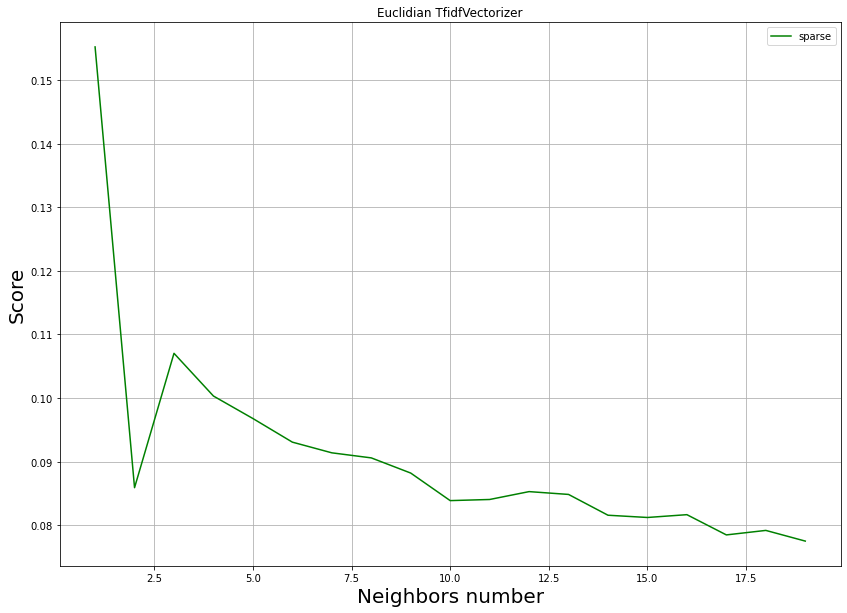

best res:  0.1552057388720959  neighbours:  1


In [29]:
results = validation(skf, X, target)
visualize_graph(results, max_points, title = "Euclidian TfidfVectorizer")

0.560544373213785
0.514583069112487
0.5494963564003874
0.5657596826219032
0.5807846039789996
0.5880324805807638
0.5936891735490631
0.5995230526654131
0.6038538139523417
0.6087149151039087
0.608980354529774
0.6106595805330611
0.6087151260119014
0.6111902250425776
0.6156096614233065
0.6134882785305318
0.6139301542093626
0.6152559452854048
0.6180844089406616


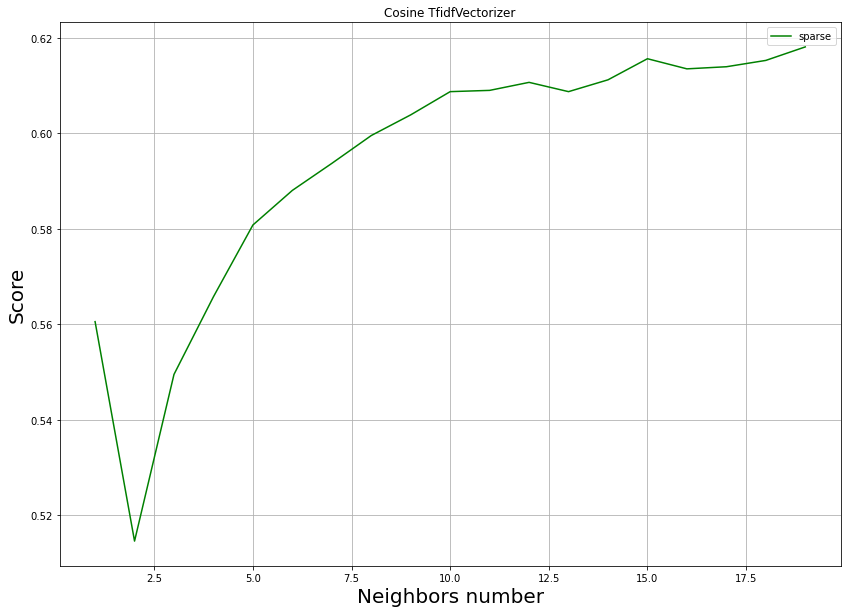

best res:  0.6180844089406616  neighbours:  19


In [30]:
results = validation(skf, X, target, metric = "cosine")
visualize_graph(results, max_points, title = "Cosine TfidfVectorizer")

Лучшая модель - TfidfVectorizer с косинусной метрикой при 19 соседях

In [31]:
my_clf1 = MyKNeighborsClassifier(n_neighbors=19, algorithm='brute')
my_clf1.fit(X, target)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [32]:
newsgroups = fetch_20newsgroups(subset='test', remove=['headers', 'footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [33]:
data = newsgroups['data']
target = newsgroups['target']

In [34]:
X1 = vectorizer.transform(data)

In [35]:
accuracy_score(target, my_clf1.predict(X1, metric = "cosine"))

0.5736856080722251

Точность на тесте ниже, поскольку test часть может отличаться от train набором слов и их частотами. Мы не можем полностью
избавиться от эффекта переобучения - подстраивания модели под тестовую часть выборки